In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
import astropy
from astropy import constants as ac
from astroquery.mast import Observations
import lightkurve
import celerite
from celerite import terms
from scipy.optimize import minimize
from astropy.io import fits
from astropy.table import Table

### Loading in TESS Sector 14 Data

In [2]:
from lightkurve import search_lightcurvefile
from lightkurve import search_targetpixelfile
target = '273589987'
gj1243_tess = search_lightcurvefile(target,cadence='short').download_all()

In [3]:
gj1243_tess[11].time

array([1683.35617589, 1683.3575648 , 1683.35895371, ..., 1710.20359189,
       1710.20498078, 1710.20636967])

In [4]:
tess_collection=gj1243_tess[-2:]
tess_collection

[TessLightCurveFile(TICID: 273589987), TessLightCurveFile(TICID: 273589987)]

In [5]:
print(gj1243_tess[11].PDCSAP_FLUX)

TessLightCurve(TICID: 273589987)


In [6]:
gj1243_tesslc = tess_collection[0].PDCSAP_FLUX

for q in range(1,len(tess_collection)):
    try:
        gj1243_tesslc = gj1243_tesslc.append(tess_collection[q].PDCSAP_FLUX)
    except:
            print(q)

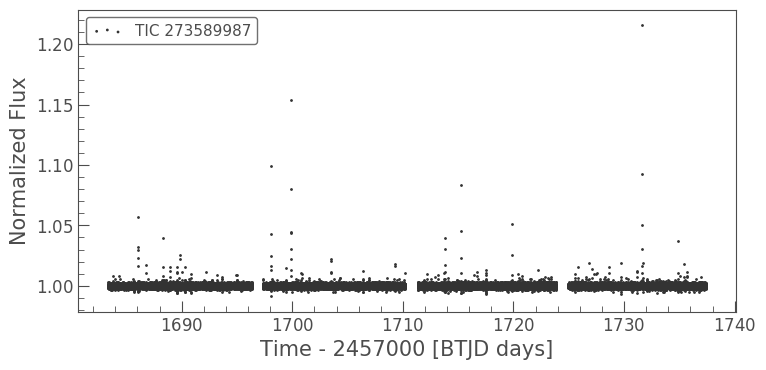

In [7]:
gj1243_tesslc.flatten(window_length=11).scatter()

### Loading in Flare tables

In [8]:
#Sector 14
fbeye14 = pd.read_csv('gj1243_tess_flares.dat.fbeye',delim_whitespace=True,comment='#',names = ['Event_ID', 'Start_INDX', 'Stop_INDX', 't_peak', 't_start', 't_stop', 't_rise', 't_decay', 
            'Flux_peak', 'Equiv_Dur', 'S/N', 'CPLX_flg', 'MLTPK_flg', 'MLTPK_num', 't_MLTPK', 'L_mltpk', 
            'MLTPK_INDX', 'quies','x'])[1:]

In [9]:
#Sector 15
fbeye15 = pd.read_csv('gj1243_tess15.dat.fbeye',delim_whitespace=True,comment='#',names = ['Event_ID', 'Start_INDX', 'Stop_INDX', 't_peak', 't_start', 't_stop', 't_rise', 't_decay', 
            'Flux_peak', 'Equiv_Dur', 'S/N', 'CPLX_flg', 'MLTPK_flg', 'MLTPK_num', 't_MLTPK', 'L_mltpk', 
            'MLTPK_INDX', 'quies','x'])[1:]

In [10]:
#combine the two fbeye files
filenames = ['gj1243_tess_flares.dat.fbeye', 'gj1243_tess15.dat.fbeye']
with open('/Users/lupitatovar/TESS/all_tess_flares.txt', 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            outfile.write(infile.read())
            

In [11]:
all_tess_flares= pd.read_csv('all_tess_flares.txt',delim_whitespace=True,comment='#',names = ['Event_ID', 'Start_INDX', 'Stop_INDX', 't_peak', 't_start', 't_stop', 't_rise', 't_decay', 
            'Flux_peak', 'Equiv_Dur', 'S/N', 'CPLX_flg', 'MLTPK_flg', 'MLTPK_num', 't_MLTPK', 'L_mltpk', 
            'MLTPK_INDX', 'quies','x'])[1:]

In [12]:
#mask the flares we found
t_starts = all_tess_flares.loc[:,'t_start'].values
t_stops = all_tess_flares.loc[:,'t_stop'].values
flux_peak = all_tess_flares.loc[:,'Flux_peak'].values

#mask array for TESS lightcurve
f_mask = np.zeros_like(gj1243_tesslc.time, dtype=bool)

In [13]:
for i in range(len(t_starts)):
    temp = (gj1243_tesslc.time >= t_starts[i]) & (gj1243_tesslc.time <= t_stops[i])
    f_mask = f_mask + temp 
print(f_mask)


no_flare = np.where((f_mask == False))[0]
flares = np.where((f_mask == True))[0]

[False False False ... False False False]


In [14]:
gj1243_tesslc.flux

array([11345.931, 11363.001, 11350.188, ..., 10954.027, 10940.631,
       10977.876], dtype=float32)

In [15]:
flat_lc = gj1243_tesslc.flatten()
flares_x=flat_lc.time[f_mask]
#flares_x[:9200]
flares_y = flat_lc.flux[f_mask]/np.nanmedian(flat_lc.flux)
print(len(flares_y[:9350]))
#print(len(gj1243_tess[11].flux[f_mask]/np.nanmedian(gj1243_tesslc.flux[f_mask])))

1725


In [16]:
flat_lc.time[29000:]

array([1727.12706733, 1727.1284562 , 1727.12984506, ..., 1737.40884054,
       1737.4102294 , 1737.41161827])

### Plotting the TESS lightcurve with identified flares

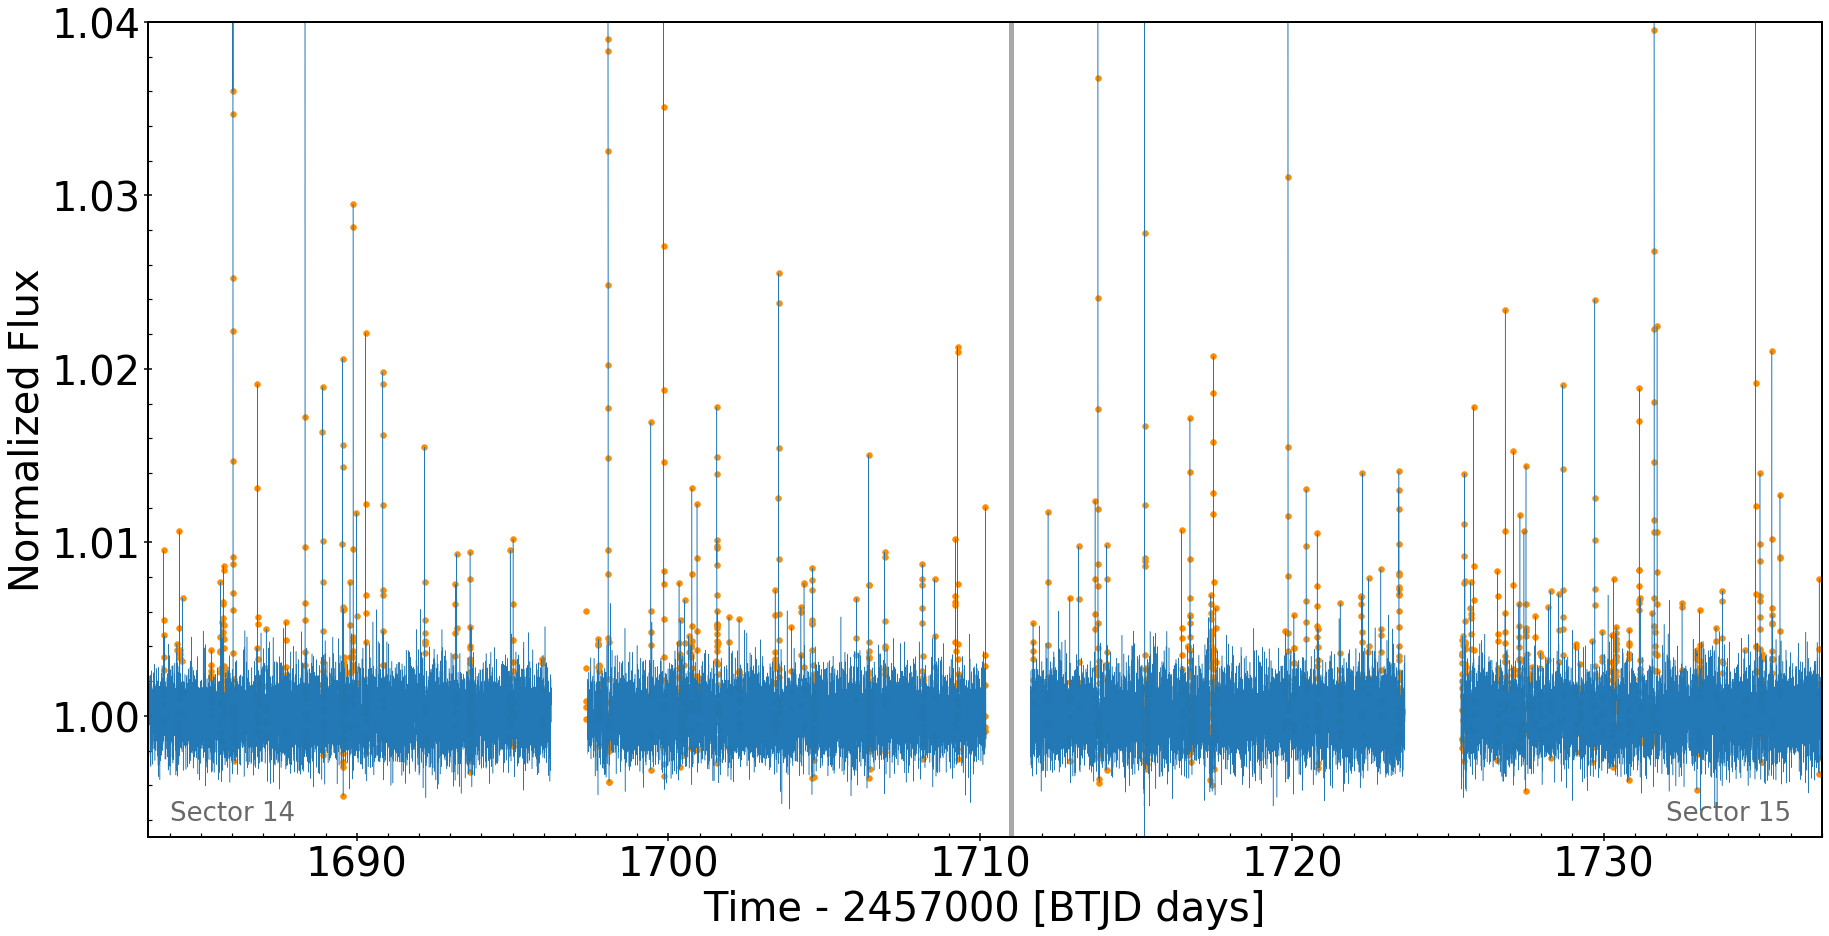

In [31]:
fig,ax = plt.subplots(figsize=(30,15))
font = {'size'   : 40}
plt.rc('font', **font)

#plotting the TESS light curve (exculdes missing data)
plt.plot(flat_lc.time[:9200],flat_lc.flux[:9200]/np.nanmedian(flat_lc.flux),linewidth=0.5,alpha=0.99,color='C0')
plt.plot(flat_lc.time[9350:18510],flat_lc.flux[9350:18510]/np.nanmedian(flat_lc.flux),linewidth=0.5,color='C0',alpha=0.99)
plt.plot(flat_lc.time[18700:27300],flat_lc.flux[18700:27300]/np.nanmedian(flat_lc.flux),linewidth=0.5,color='C0',alpha=0.99)
plt.plot(flat_lc.time[27800:],flat_lc.flux[27800:]/np.nanmedian(flat_lc.flux),linewidth=0.5,color='C0',alpha=0.99)

plt.scatter(flares_x,flares_y,linewidth=0.5,color='darkorange',s=35)

#line to sperate sectors
plt.axvline(x=1711, color='darkgrey',linewidth=5)

#Text
plt.text(1684, .994, 'Sector 14', fontsize=26, color ='dimgrey')
plt.text(1732, .994, 'Sector 15', fontsize=26, color ='dimgrey')

#axes
ax.set_ylim([0.993,1.04])
ax.set_xlim([1683.3,1737])
plt.rcParams['axes.linewidth']=2

plt.tick_params(axis='both',direction="in")
from matplotlib.ticker import (AutoMinorLocator,MultipleLocator)
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.tick_params(which='minor', direction='in',width=1.2,length=4)
ax.yaxis.set_minor_locator(MultipleLocator(.002))

plt.tick_params(axis='both',direction="in",width=1.5,length=8)


plt.xlabel('Time - 2457000 [BTJD days]')
plt.ylabel('Normalized Flux')
plt.tick_params(axis='both',direction="inout")

#subplots for 1 day zoom in


#plt.savefig('gj1243_tess_lc.pdf',dpi=300, bbox_inches='tight', pad_inches=0.5)

In [18]:
#flat_lc.time[1:400],flat_lc.flux[2:5]

(1685.71, 1686.85)

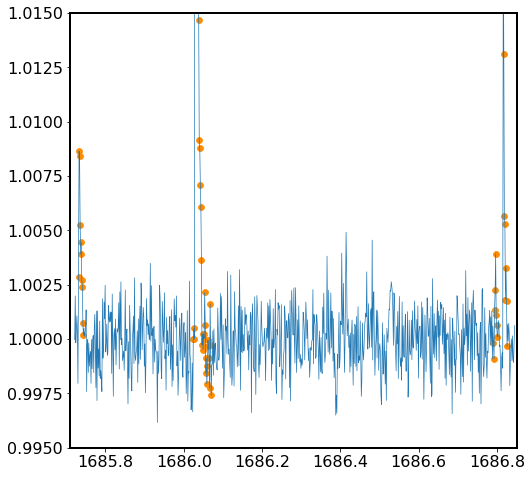

In [33]:
#one day of flares for sector 14
fig,ax = plt.subplots(figsize=(8,8))
font = {'size'   : 16}
plt.rc('font', **font)
plt.plot(flat_lc.time[1690:2500],flat_lc.flux[1690:2500]/np.nanmedian(flat_lc.flux),linewidth=0.7,alpha=5,color='C0')
plt.scatter(flares_x[70:130],flares_y[70:130],linewidth=0.8,color='darkorange',s=35)
ax.set_ylim([0.995,1.015])
ax.set_xlim([1685.71,1686.85])

(1727.6, 1728.6)

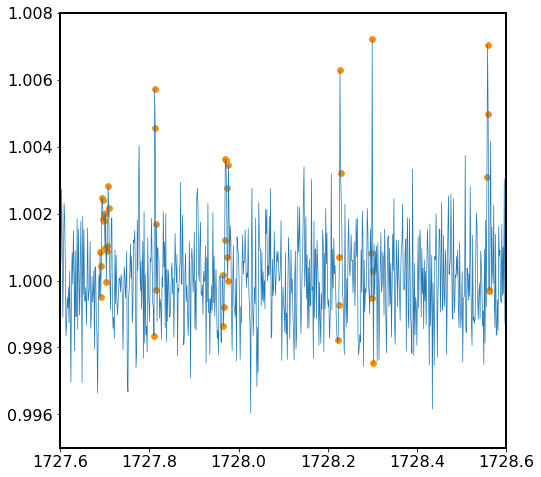

In [20]:
#one day of flares for sector 15
fig,ax = plt.subplots(figsize=(8,8))
font = {'size'   : 16}
plt.rc('font', **font)
plt.plot(flat_lc.time[29290:30130],flat_lc.flux[29290:30130]/np.nanmedian(flat_lc.flux),linewidth=0.7,alpha=5,color='C0')
plt.scatter(flares_x[1400:1452],flares_y[1400:1452],linewidth=0.8,color='darkorange',s=35)
ax.set_ylim([0.995,1.008])
ax.set_xlim([1727.6,1728.6])

### TESS FFD

In [21]:
Lo=30.352907
ED = np.sort(all_tess_flares['Equiv_Dur'][::-1])
time = (np.nanmedian(np.diff(flat_lc.time))) * (len(flat_lc.time))
nu = (np.arange(1, len(ED)+1)) / time

tess_x = np.log10(ED)[::-1] + (Lo)
#is is log(Lo)???
tess_y = np.log10(nu)

/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


Text(0.5, 1.0, 'GJ 1243 - TESS Sector 14')

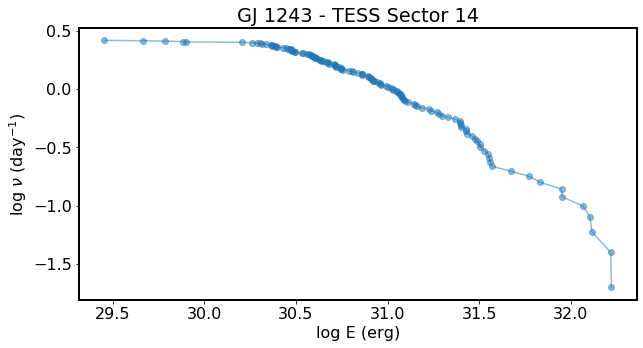

In [22]:
fig = plt.figure(figsize=(10,5))
font = {'size'   : 16}
plt.rc('font', **font)

plt.plot(tess_x,tess_y,'-o', color='C0', alpha=0.5)
plt.xlabel('log E (erg)')
plt.ylabel(r'log $\nu$ (day$^{-1}$)')
plt.title('GJ 1243 - TESS Sector 14')

### Loading in Kepler data & flares from Davenport et al (2014)

In [23]:
# Kepler Flares
kep_Lo = 30.037849     #Jim calculated this value long time ago

kep_lc = pd.read_csv('https://raw.githubusercontent.com/jradavenport/GJ1243-Flares/1732d4130daf663532596749d566d8f78be8f7b2/data/gj1243_master_slc.dat', delim_whitespace=True, skiprows=1, 
                       names=('time', 'flux', 'error', 'detrended_flux'))
kep_dur = len(kep_lc) * 58.0 / 60./60./24.

kep_flare_table=pd.read_csv('https://raw.githubusercontent.com/jradavenport/GJ1243-Flares/master/data/gj1243_master_flares.tbl',
            skiprows=23,delim_whitespace=True,names=['index of flare start in "gj1243_master_slc.dat"',
                                                   'index of flare stop in "gj1243_master_slc.dat"','t_start','t_stop'
                                                   ,'t_peak','t_rise','t_decay','flux peak',
                                                   'ED','Duration of rise',
                                                   'Duration of decay','Complex flag',
                                                   '# of people that identified flare event exists',
                                                   '# of people that analyzed this month',
                                                   '# of flare template components fit to event'])

In [24]:
kep_x = np.log10(np.sort(kep_flare_table['ED'])[::-1]) + kep_Lo
kep_y = np.log10(np.arange(1, len(kep_x)+1) / kep_dur)

/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


In [25]:
dL = 30.665290 - 30.037849
dL

0.6274409999999975

### Fitting the TESS Data

[-0.94881011 29.42930286] [0.02169461 0.67623133]


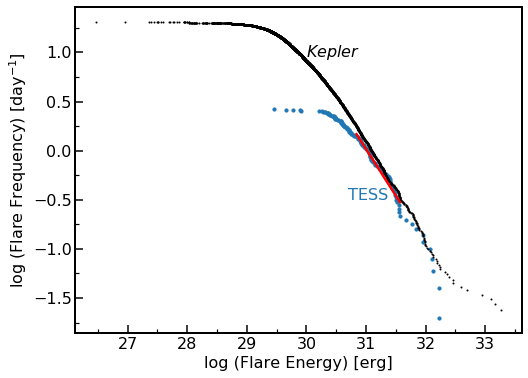

In [26]:
fig,ax = plt.subplots(figsize=(8,6))
font = {'size'   : 18}
plt.rc('font', **font)

plt.scatter(tess_x,tess_y, color='C0',s=10) #, label='TESS'
plt.scatter(kep_x,kep_y, color='k',s=1)
plt.xlabel('log (Flare Energy) [erg]')
plt.ylabel(r'log (Flare Frequency) [day$^{-1}$]')


# Add labels to the plot
style = dict(size=16)
ax.text(30.7, -0.5, "TESS", **style,color='C0')
ax.text(30, 0.95, "$\it{Kepler}$", **style)

#axes
plt.rcParams['axes.linewidth']=1.5

plt.tick_params(axis='both',direction="in")
from matplotlib.ticker import (AutoMinorLocator,MultipleLocator)
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.tick_params(which='minor', direction='in',width=1.2,length=4)
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
plt.tick_params(axis='both',direction="in",width=1.5,length=8)


from scipy import polyfit

tess_polyfit,cov= np.polyfit(tess_x[10:70],tess_y[10:70],1,full=False, cov=True)

plt.plot(tess_x[10:70],np.polyval(tess_polyfit,tess_x[10:70]),color='red',linewidth=2.5)
print(tess_polyfit,np.sqrt(np.diag(cov))) #uncertainities on m and b


### Fitting the Kepler Data

In [27]:
kepx_fit=np.log10(np.sort(kep_flare_table['ED'])[::-1]) + kep_Lo
no_nan_mask = np.isfinite(kep_x)

/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


In [28]:
kepy_fit=np.log10(np.arange(1, len(kep_x)+1) / kep_dur)

Kepler [-0.86276608 26.83731178] [0.00138837 0.04231651]
TESS [-0.94881011 29.42930286] [0.02169461 0.67623133]


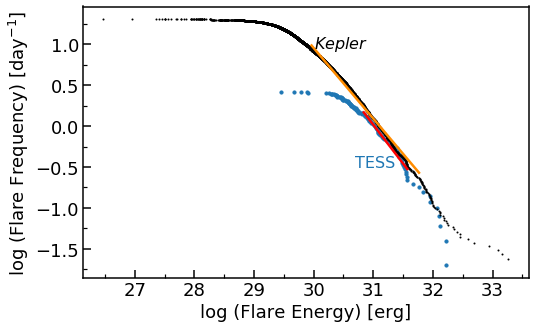

In [29]:
fig,ax = plt.subplots(figsize=(8,5))
font = {'size'   : 18}
plt.rc('font', **font)

plt.scatter(tess_x,tess_y, color='C0',s=10) #, label='TESS'
plt.scatter(kep_x,kep_y, color='k',s=1)
plt.xlabel('log (Flare Energy) [erg]')
plt.ylabel(r'log (Flare Frequency) [day$^{-1}$]')
#plt.title('GJ 1243')
#plt.legend() 

# Add labels to the plot
style = dict(size=16)
ax.text(30.7, -0.5, "TESS", **style,color='C0')
ax.text(30, 0.95, "$\it{Kepler}$", **style)

#axes
plt.rcParams['axes.linewidth']=1.5

plt.tick_params(axis='both',direction="in")
from matplotlib.ticker import (AutoMinorLocator,MultipleLocator)
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.tick_params(which='minor', direction='in',width=1.2,length=4)
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
plt.tick_params(axis='both',direction="in",width=1.5,length=8)

#fitting a line

from scipy import polyfit
kep_polyfit, cov = np.polyfit(kep_x[no_nan_mask][60:2500], kep_y[no_nan_mask][60:2500],1,full=False, cov=True)

plt.plot(kep_x[no_nan_mask][60:2500],np.polyval(kep_polyfit, kep_x[no_nan_mask][60:2500]),color='darkorange',linewidth=2.5)
kep_polyfit,np.sqrt(np.diag(cov)) #uncertainities on m and b

print('Kepler',kep_polyfit,np.sqrt(np.diag(cov)))


#Combining both fits onto one plot
tess_polyfit,cov= np.polyfit(tess_x[10:70],tess_y[10:70],1,full=False, cov=True)

plt.plot(tess_x[10:70],np.polyval(tess_polyfit,tess_x[10:70]),color='red',linewidth=2.5)
print('TESS',tess_polyfit,np.sqrt(np.diag(cov))) #uncertainities on m and b

#plt.savefig('ffd_fit.pdf',dpi=300, bbox_inches='tight', pad_inches=0.5)

### Error Propagation

In [ ]:
#Error Propagation

#Y errors
def Perror(n):
    err_down = n * (1. - 1. / (9. * n) -1./(3. * np.sqrt(n)))**3 - n
    err_up = n + np.sqrt(n + 0.75) + 1.0 - n 
    return err_down, err_up

#if the variable "ffd_y" is the cumulative # per day (NOT the log rate, yet), then you can quickly compute ffd_yerr as:

ffd_yerr = Perror(nu * time) / time

#where totdur is the total duration in days. 


#X Errors

dur = t_stops - t_starts
flux_err_tess= gj1243_tess[11].PDCSAP_FLUX.flux_err/np.nanmedian(gj1243_tess[11].PDCSAP_FLUX.flux)
S2N = ED / np.sqrt(ED + (np.nanmedian(flux_err_tess) * dur * 86400.))

logED_err = np.abs((1./S2N) / np.log(10.) / ED)

#and finally:
#ffd_x = np.log10(tess_x -Lo)
ffd_xerr = np.abs(( (1./S2N[np.argsort(ED)])[::-1] ) / np.log(10.) / (tess_x -Lo))

In [ ]:
#print(ffd_xerr)
(ffd_yerr) #do more error propagation for the log of the uncertainty since ffd_yerr is not log'd

In [ ]:
gj1243_tess[11].PDCSAP_FLUX.flux_err/np.nanmedian(gj1243_tess[11].PDCSAP_FLUX.flux)